# Compare Manual vs Automated Meta-Analysis Results

This notebook compares results from manual meta-analyses (NeuroMetaBench) with automated meta-analyses (autonima-results) using:

1. Correlation matrices (R²) between all pairs
2. Dice coefficients for spatial overlap
3. Visual comparison using nilearn plotting

In [1]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from pathlib import Path
from nilearn import plotting
import json
import os

## Setup Paths and Mappings

In [2]:
repos_dir = '/home/zorro/repos'

social_meta_path = 'neurometabench/analysis/social'
social_meta_inputs_path ='neurometabench/data/nimads/social'
social_meta_annotation_path = 'neurometabench/analysis/social/projects/social/coordinates/rev3-search-all_pmids/outputs/nimads_annotation.json'
social_automated_meta_path = 'autonima-results/projects/social/coordinates/rev3-all_pmids/outputs/meta_analysis_results'
social_full_automated_meta_path = 'autonima-results/projects/social/coordinates/rev3-search-all_pmids/outputs/meta_analysis_results'

# Mapping from NeuroMetaBench social analysis names to autonima-results social analysis names
mappings = {
    "Affiliation-Merged": 'affiliation_attachment',
    "Self-Merged": 'perception_self',
    "Others-Merged": 'perception_others',
    "SocComm-Merged": 'social_communication',
    "ALL-Merged": 'social_processing_all',
}

# Filename to load
result_file = 'z.nii.gz'

# Axial slice coordinates for visualization
display_coords = [-42, -25, -8, 10, 28, 45, 62]

In [3]:
# Load social meta-data inputs
# social_meta_data_path 
# For everyone of mappings.keys there is a .json file
# Load the JSON files corresponding to each key in mappings

manual_counts = {}
manual_json_dir = os.path.join(repos_dir, social_meta_inputs_path)

for manual_name in mappings.keys():
    json_path = os.path.join(manual_json_dir, f"{manual_name}.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            meta = json.load(f)
        n_studies = len(meta.get("studies", []))
        n_analyses = sum(len(study.get("analyses", [])) for study in meta.get("studies", []))
        manual_counts[manual_name] = {"studies": n_studies, "analyses": n_analyses}
    else:
        print(f"Manual JSON not found: {json_path}")
        manual_counts[manual_name] = {"studies": 0, "analyses": 0}

print("\nManual Meta-Analysis Counts:")
for k, v in manual_counts.items():
    print(f"{k}: {v['studies']} studies, {v['analyses']} analyses")



Manual Meta-Analysis Counts:
Affiliation-Merged: 34 studies, 106 analyses
Self-Merged: 66 studies, 206 analyses
Others-Merged: 130 studies, 405 analyses
SocComm-Merged: 108 studies, 381 analyses
ALL-Merged: 242 studies, 855 analyses


In [4]:
auto_json_path = os.path.join(repos_dir, social_automated_meta_path.replace('meta_analysis_results', 'nimads_annotation.json'))
if not os.path.exists(auto_json_path):
    auto_json_path = "projects/social/coordinates/rev3-search-all_pmids/outputs/nimads_annotation.json"

with open(auto_json_path, "r") as f:
    auto_meta = json.load(f)


def _compute_counts(meta):
    notes = meta["notes"]

    # Count analyses per boolean column
    counts = {k: 0 for k in meta["note_keys"].keys()}
    pmids = set()
    for note in notes:
        for k in counts:
            if note["note"].get(k, False):
                counts[k] += 1
        # Extract PMID from analysis name (e.g., "11050021_analysis_0")
        pmid = note["analysis"].split("_analysis_")[0]
        pmids.add(pmid)
    return counts, pmids

auto_counts, pmids = _compute_counts(auto_meta)


auto_json_path = os.path.join(repos_dir, social_full_automated_meta_path.replace('meta_analysis_results', 'nimads_annotation.json'))
if not os.path.exists(auto_json_path):
    auto_json_path = "projects/social/coordinates/rev3-search-all_pmids/outputs/nimads_annotation.json"

with open(auto_json_path, "r") as f:
    full_auto_meta = json.load(f)

full_auto_counts, pmids = _compute_counts(full_auto_meta)

print("\nAutomated Meta-Analysis Counts:")
for k, v in full_auto_counts.items():
    print(f"{k}: {v} analyses")
print(f"Unique PMIDs (studies): {len(pmids)}")

print("\nAutomated Meta-Analysis Counts:")
for k, v in auto_counts.items():
    print(f"{k}: {v} analyses")
print(f"Unique PMIDs (studies): {len(pmids)}")




Automated Meta-Analysis Counts:
all_analyses: 1606 analyses
all_studies: 1921 analyses
social_processing_all: 1344 analyses
affiliation_attachment: 185 analyses
social_communication: 623 analyses
perception_self: 167 analyses
perception_others: 1113 analyses
Unique PMIDs (studies): 482

Automated Meta-Analysis Counts:
all_analyses: 805 analyses
all_studies: 856 analyses
social_processing_all: 624 analyses
perception_self: 213 analyses
affiliation_attachment: 202 analyses
social_communication: 526 analyses
perception_others: 548 analyses
Unique PMIDs (studies): 482


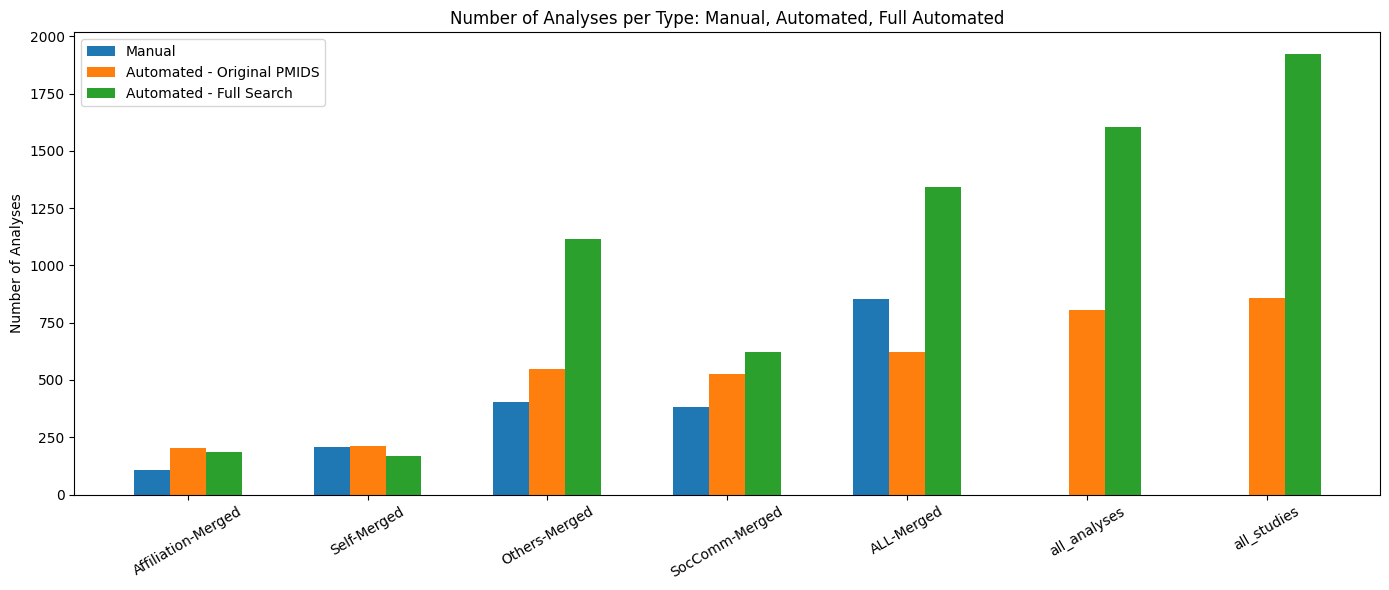

In [5]:
analysis_types = list(mappings.keys()) + ['all_analyses', 'all_studies']
manual_n = [manual_counts.get(name, {}).get('analyses', 0) for name in analysis_types]
automated_n = [auto_counts.get(mappings.get(name, name), 0) for name in analysis_types]
full_automated_n = [full_auto_counts.get(mappings.get(name, name), 0) for name in analysis_types]

x = range(len(analysis_types))
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar([i - 0.2 for i in x], manual_n, width=0.2, label='Manual')
ax.bar(x, automated_n, width=0.2, label='Automated - Original PMIDS')
ax.bar([i + 0.2 for i in x], full_automated_n, width=0.2, label='Automated - Full Search')
ax.set_xticks(x)
ax.set_xticklabels(analysis_types, rotation=30)
ax.set_ylabel('Number of Analyses')
ax.set_title('Number of Analyses per Type: Manual, Automated, Full Automated')
ax.legend()
plt.tight_layout()
plt.show()



## Load All NIfTI Files

In [19]:
def load_nifti_data(base_dir, subdir, filename):
    """Load a NIfTI file and return the data array."""
    filepath = os.path.join(base_dir, subdir, filename)
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None, None
    
    img = nib.load(filepath)
    data = img.get_fdata()
    return data, filepath

# Load manual meta-analysis results
manual_data = {}
manual_paths = {}
for manual_name in mappings.keys():
    manual_dir = os.path.join(repos_dir, social_meta_path, manual_name)
    data, filepath = load_nifti_data(repos_dir, os.path.join(social_meta_path, manual_name), result_file)
    if data is not None:
        manual_data[manual_name] = data
        manual_paths[manual_name] = filepath

# Load automated meta-analysis results
automated_data = {}
automated_paths = {}
for manual_name, auto_name in mappings.items():
    auto_dir = os.path.join(social_automated_meta_path, auto_name)
    data, filepath = load_nifti_data(repos_dir, auto_dir, result_file)
    if data is not None:
        automated_data[manual_name] = data
        automated_paths[manual_name] = filepath

# Also load all no selection 
for auto_name in ['all_analyses', 'all_studies']:
    auto_dir = os.path.join(social_automated_meta_path, auto_name)
    data, filepath = load_nifti_data(repos_dir, auto_dir, result_file)
    automated_data[auto_name] = data
    automated_paths[auto_name] = filepath

# Load search-based automated meta-analysis results
fullautomated_data = {}
fullautomated_paths = {}
for manual_name, auto_name in mappings.items():
    auto_dir = os.path.join(social_full_automated_meta_path, auto_name)
    data, filepath = load_nifti_data(repos_dir, auto_dir, result_file)
    if data is not None:
        fullautomated_data[manual_name] = data
        fullautomated_paths[manual_name] = filepath

# Also load all no selection 
for auto_name in ['all_analyses', 'all_studies']:
    auto_dir = os.path.join(social_full_automated_meta_path, auto_name)
    data, filepath = load_nifti_data(repos_dir, auto_dir, result_file)
    fullautomated_data[auto_name] = data
    fullautomated_paths[auto_name] = filepath

## Visualize All Images Using Nilearn

### Paired Manual and Automated Results

In [20]:
# for name in sorted(manual_paths.keys()):
#     print(f"\n{'='*70}")
#     print(f"COMPARISON: {name}")
#     print(f"{'='*70}")
    
#     fig, axes = plt.subplots(2, 1, figsize=(15, 7))
    
#     # Manual (thresholded)
#     display1 = plotting.plot_stat_map(
#         manual_paths[name],
#         display_mode='z',
#         cut_coords=display_coords,
#         title=f"Manual (Thresholded): {name}",
#         colorbar=True,
#         cmap='RdBu_r',
#         symmetric_cbar=True,
#         threshold=1.96,
#         vmax=10,
#         axes=axes[0],
#         figure=fig
#     )
    
#     # Automated (thresholded)
#     display2 = plotting.plot_stat_map(
#         automated_thresholded_paths[name],
#         display_mode='z',
#         cut_coords=display_coords,
#         title=f"Automated (Thresholded): {name} ({mappings[name]})",
#         colorbar=True,
#         cmap='RdBu_r',
#         symmetric_cbar=True,
#         threshold=1.96,
#         vmax=10,
#         axes=axes[1],
#         figure=fig
#     )
    
#     plt.tight_layout()
#     plt.savefig(f'comparison_thresholded_{name.replace("-", "_").lower()}.png', dpi=300, bbox_inches='tight')
#     plt.show()

## Flatten data & Create Mask for Common Valid Voxels

In [21]:
def flatten_data(data_dict):
    """Flatten 3D brain data to 1D vectors, removing NaN/Inf values."""
    flattened = {}
    for name, data in data_dict.items():
        flat = data.flatten()
        # Remove NaN and Inf values
        valid_mask = np.isfinite(flat)
        flattened[name] = flat[valid_mask]
    return flattened


manual_flat = flatten_data(manual_data)
automated_flat = flatten_data(automated_data)
fullautomated_flat = flatten_data(fullautomated_data)

def create_common_mask(data_dict):
    """Create a mask of voxels that are valid (finite) across all images."""
    masks = []
    for name, data in data_dict.items():
        masks.append(np.isfinite(data))
    
    if len(masks) == 0:
        return None
    
    # Combine all masks - voxel must be valid in ALL images
    common_mask = masks[0]
    for mask in masks[1:]:
        common_mask = common_mask & mask
    
    print(f"Common mask: {np.sum(common_mask)} valid voxels")
    return common_mask

# Create common mask across all data
all_data = {**manual_data, **automated_data, **fullautomated_data}
common_mask = create_common_mask(all_data)

# Apply common mask to all data
manual_masked = {name: data.flatten()[common_mask.flatten()] for name, data in manual_data.items()}
automated_masked = {name: data.flatten()[common_mask.flatten()] for name, data in automated_data.items()}
fullautomated_masked = {name: data.flatten()[common_mask.flatten()] for name, data in fullautomated_data.items()}


Common mask: 902629 valid voxels


In [22]:
def compute_correlation_matrix(manual_dict, automated_dict):
    """Compute correlation matrix between all manual and automated analyses."""
    analysis_names = list(automated_dict.keys())
    manual_names = list(manual_dict.keys())
    n = len(analysis_names)
    n_cols = len(manual_names)
    
    # Create matrix: rows are manual, columns are automated
    corr_matrix = np.zeros((n_cols, n))
    r2_matrix = np.zeros((n_cols, n))
    
    for i, manual_name in enumerate(analysis_names):
        for j, auto_key in enumerate(analysis_names):
            if manual_name not in manual_dict:
                continue
            manual_vec = manual_dict[manual_name]
            auto_vec = automated_dict[auto_key]
            
            # Compute Pearson correlation
            r, p = pearsonr(manual_vec, auto_vec)
            corr_matrix[i, j] = r
            r2_matrix[i, j] = r**2
    
    return corr_matrix, r2_matrix, analysis_names, manual_names

def compute_dice_coefficient(img1, img2, threshold=0):
    """Compute Dice coefficient between two binary masks.
    
    Args:
        img1, img2: Arrays to compare
        threshold: Threshold to binarize images (default: 0)
    
    Returns:
        dice: Dice coefficient (0-1)
    """
    # Binarize images
    binary1 = img1 > threshold
    binary2 = img2 > threshold
    
    # Compute intersection and union
    intersection = np.sum(binary1 & binary2)
    sum_volumes = np.sum(binary1) + np.sum(binary2)
    
    if sum_volumes == 0:
        return 0.0
    
    dice = (2.0 * intersection) / sum_volumes
    return dice

def compute_dice_matrix_pairwise(manual_dict, automated_dict, threshold=0):
    manual_names = list(manual_dict.keys())
    auto_names = list(automated_dict.keys())
    dice_matrix = np.zeros((len(manual_names), len(auto_names)))
    for i, manual_name in enumerate(manual_names):
        for j, auto_name in enumerate(auto_names):
            manual_vec = manual_dict[manual_name]
            auto_vec = automated_dict[auto_name]
            dice = compute_dice_coefficient(manual_vec, auto_vec, threshold)
            dice_matrix[i, j] = dice
    return dice_matrix, manual_names, auto_names



## N Analyses

## Baseline - Correlation Matrix between original results

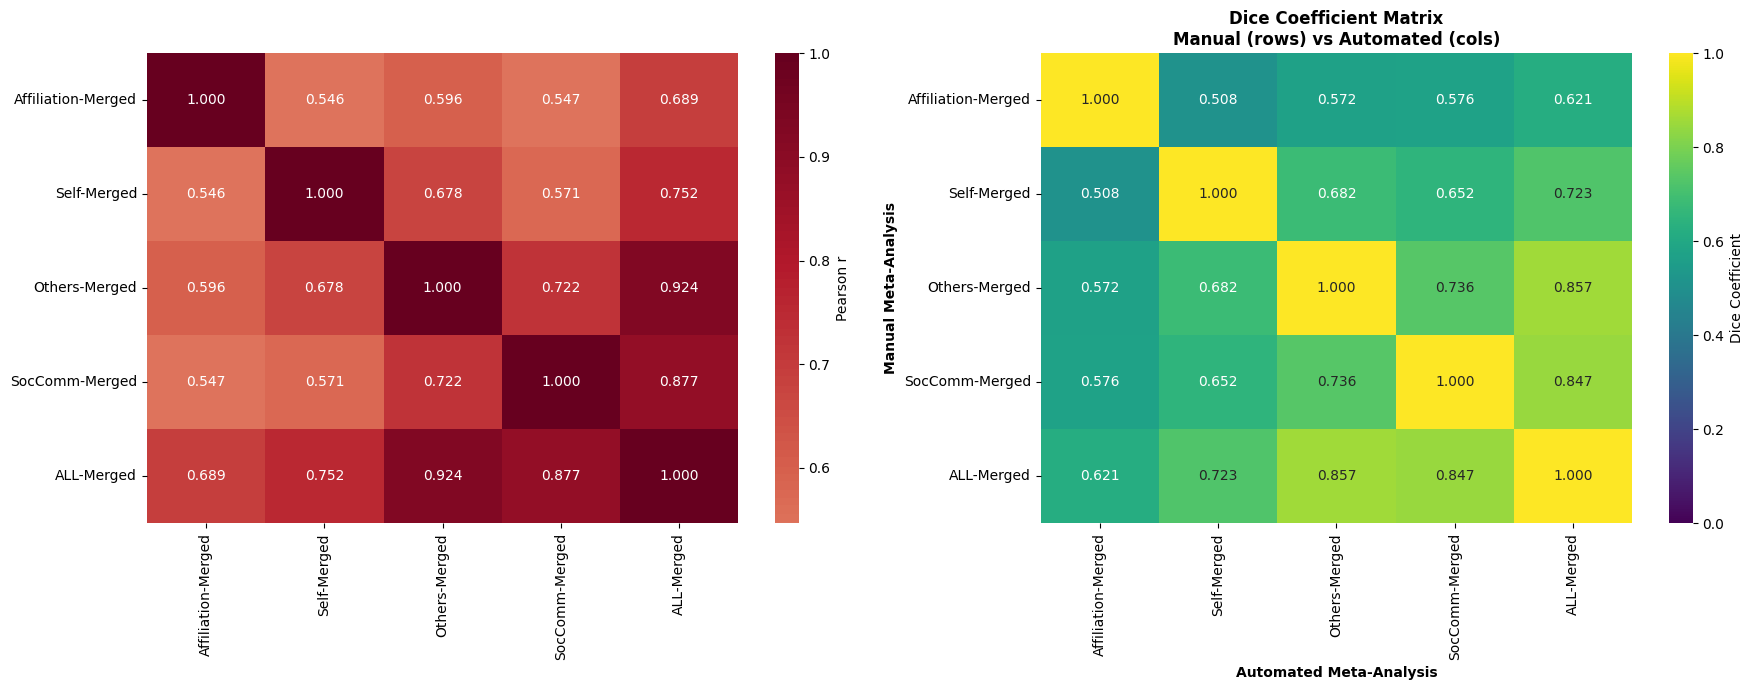

In [23]:
corr_matrix_orig, r2_matrix_orig, analysis_names_auto, _ = compute_correlation_matrix(manual_masked, manual_masked)
dice_matrix_arr, manual_names_dice, auto_names_dice = compute_dice_matrix_pairwise(manual_masked, manual_masked)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))


# Set cmap and vmin/vmax based on the range of corr_matrix values
vmin_corr = np.min(corr_matrix_orig)
vmax_corr = np.max(corr_matrix_orig)
sns.heatmap(corr_matrix_orig, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            xticklabels=analysis_names_auto, yticklabels=analysis_names_auto,
            vmin=vmin_corr, vmax=vmax_corr, ax=axes[0], cbar_kws={'label': 'Pearson r'})

sns.heatmap(dice_matrix_arr, annot=True, fmt='.3f', cmap='viridis',
            xticklabels=manual_names_dice, yticklabels=auto_names_dice,
            vmin=0, vmax=1, ax=axes[1], cbar_kws={'label': 'Dice Coefficient'})
axes[1].set_title('Dice Coefficient Matrix\nManual (rows) vs Automated (cols)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Automated Meta-Analysis', fontweight='bold')
axes[1].set_ylabel('Manual Meta-Analysis', fontweight='bold')

plt.tight_layout()
plt.savefig('correlation_dice_combined.png', dpi=300, bbox_inches='tight')
plt.show()


## Compute Correlation Matrix (R²)

In [24]:
corr_matrix, r2_matrix, auto_names, manual_names = compute_correlation_matrix(manual_masked, automated_masked)
fullcorr_matrix, fullr2_matrix, fullauto_names, fullmanual_names = compute_correlation_matrix(manual_masked, fullautomated_masked)

## Visualize Correlation Matrix

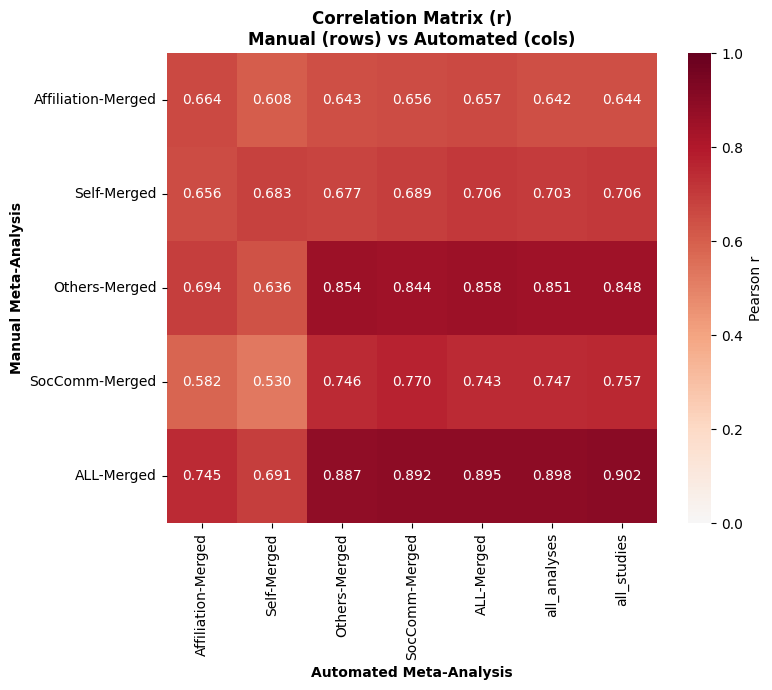

In [25]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            xticklabels=auto_names, yticklabels=manual_names,
            vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Pearson r'})
ax.set_title('Correlation Matrix (r)\nManual (rows) vs Automated (cols)', fontsize=12, fontweight='bold')
ax.set_xlabel('Automated Meta-Analysis', fontweight='bold')
ax.set_ylabel('Manual Meta-Analysis', fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix_only.png', dpi=300, bbox_inches='tight')
plt.show()


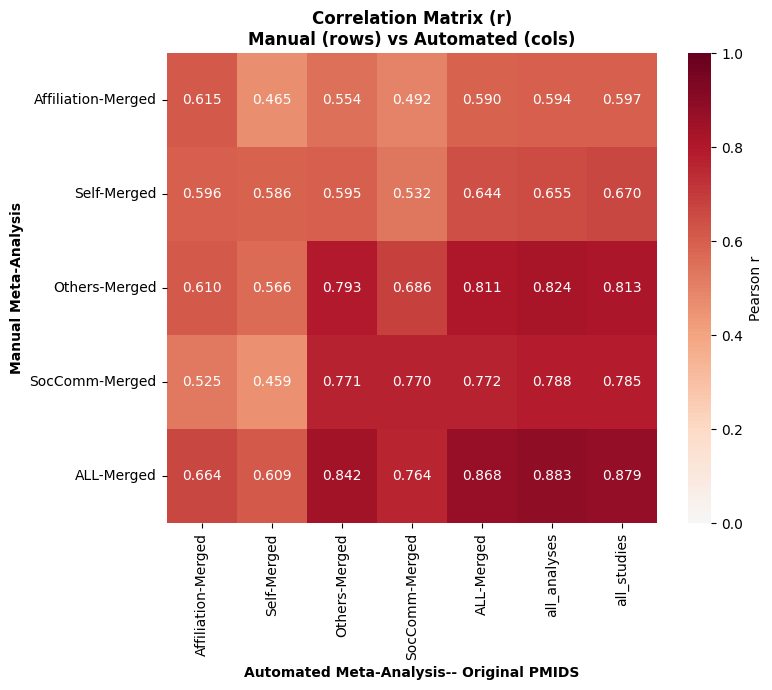

In [26]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(fullcorr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            xticklabels=auto_names, yticklabels=manual_names,
            vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Pearson r'})
ax.set_title('Correlation Matrix (r)\nManual (rows) vs Automated (cols)', fontsize=12, fontweight='bold')
ax.set_xlabel('Automated Meta-Analysis-- Original PMIDS', fontweight='bold')
ax.set_ylabel('Manual Meta-Analysis', fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix_full-auto.png', dpi=300, bbox_inches='tight')
plt.show()


## Compute Dice Coefficients b/w Manual and Automated

In [31]:
# Compute Dice coefficients using thresholded maps
dice_matrix, manual_names, auto_names = compute_dice_matrix_pairwise(manual_masked, automated_masked, threshold=1.96)
dice_matrix_full, manual_names_full, auto_names_full = compute_dice_matrix_pairwise(manual_masked, fullautomated_masked, threshold=1.96)


## Visualize Dice Coefficient Matrix

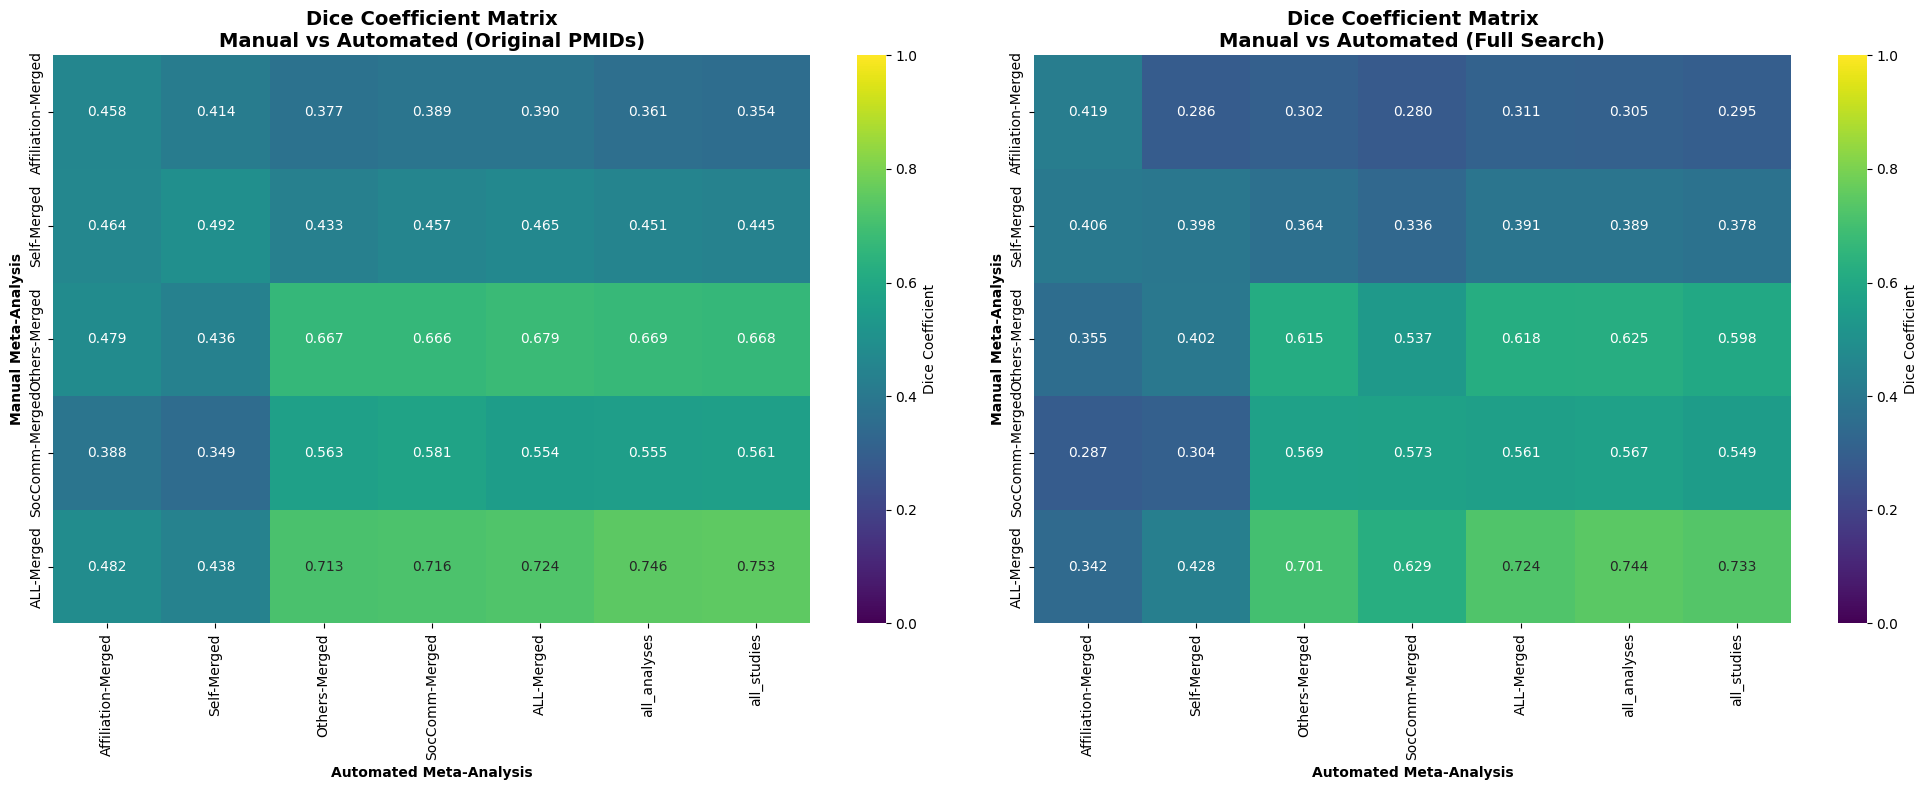

<Figure size 640x480 with 0 Axes>

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: Dice matrix for original automated results
sns.heatmap(dice_matrix, annot=True, fmt='.3f', cmap='viridis',
            xticklabels=auto_names, yticklabels=manual_names,
            vmin=0, vmax=1, ax=axes[0], cbar_kws={'label': 'Dice Coefficient'})
axes[0].set_title('Dice Coefficient Matrix\nManual vs Automated (Original PMIDs)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Automated Meta-Analysis', fontweight='bold')
axes[0].set_ylabel('Manual Meta-Analysis', fontweight='bold')

# Right: Dice matrix for full automated results
sns.heatmap(dice_matrix_full, annot=True, fmt='.3f', cmap='viridis',
            xticklabels=auto_names, yticklabels=manual_names,
            vmin=0, vmax=1, ax=axes[1], cbar_kws={'label': 'Dice Coefficient'})
axes[1].set_title('Dice Coefficient Matrix\nManual vs Automated (Full Search)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Automated Meta-Analysis', fontweight='bold')
axes[1].set_ylabel('Manual Meta-Analysis', fontweight='bold')

plt.tight_layout()
plt.savefig('dice_coefficient_matrix_combined.png', dpi=300, bbox_inches='tight')
plt.show()

sns.heatmap(dice_matrix_full, annot=True, fmt='.3f', cmap='viridis',
            xticklabels=auto_names, yticklabels=manual_names,
            vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Dice Coefficient'})

ax.set_title('Dice Coefficient Matrix\nManual (rows) vs Automated (cols)', fontsize=14, fontweight='bold')
ax.set_xlabel('Automated Meta-Analysis', fontweight='bold')
ax.set_ylabel('Manual Meta-Analysis', fontweight='bold')

plt.tight_layout()
plt.savefig('dice_coefficient_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


## Side-by-Side Comparison: Single Axial Slice at z=-10

In [ ]:
nice_names = {
    "Affiliation-Merged": "Affiliation",
    "Self-Merged": "Self",
    "Others-Merged": "Others",
    "SocComm-Merged": "Social Communication",
    "ALL-Merged": "All Social"
}

# Create a single figure with all comparisons
n_comparisons = len(manual_paths.keys())
fig, axes = plt.subplots(n_comparisons, 2, figsize=(10, 2.5 * n_comparisons))

for idx, name in enumerate(sorted(manual_paths.keys())):
    print(f"Processing: {name}")
    
    # Manual (left column)
    display1 = plotting.plot_stat_map(
        manual_paths[name],
        display_mode='z',
        cut_coords=[-10],
        title=None,
        colorbar=False,
        cmap='RdBu_r',
        symmetric_cbar=True,
        threshold=1.96,
        vmax=10,
        axes=axes[idx, 0],
        figure=fig
    )
    
    # Automated (right column)
    display2 = plotting.plot_stat_map(
        automated_paths[name],
        display_mode='z',
        cut_coords=[-10],
        title=None,
        colorbar=False,
        cmap='RdBu_r',
        symmetric_cbar=True,
        threshold=1.96,
        vmax=10,
        axes=axes[idx, 1],
        figure=fig
    )
    
    # Add row label on the left side
    nice_title = nice_names.get(name, name)
    axes[idx, 0].text(-0.15, 0.5, nice_title, 
                      transform=axes[idx, 0].transAxes,
                      ha='right', va='center', 
                      fontsize=12, fontweight='bold',
                      rotation=90)

# Add column headers
axes[0, 0].set_title('Manual', fontsize=14, fontweight='bold', pad=10)
axes[0, 1].set_title('Automated', fontsize=14, fontweight='bold', pad=10)

# Adjust spacing to reduce whitespace
plt.subplots_adjust(left=0.12, right=0.98, top=0.96, bottom=0.02, hspace=0.15, wspace=0.05)
plt.savefig('comparison_single_slice_all.png', dpi=300, bbox_inches='tight')
plt.show()

### Apples to Apples comparison with manual subset that overlaps with automated subset

In [16]:
## TODO: Need to annotate original manual meta-analysis' input analyses with pmids, to filter to only include relevant studies
## - Another idea is to then use the paired pmids to directly compare overlapping analyses to automated results